In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
# !wget $data

In [4]:
df = pd.read_csv("CreditScoring.csv")
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


# Data preparation

In [8]:
df.columns = df.columns.str.lower()
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [9]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

df = df[df.status != 'unk'].reset_index(drop=True)

# Train test split

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [13]:
del df_train['status']
del df_val['status']
del df_test['status']

# Model building

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [16]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)


dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6548400377806302

In [18]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- home=parents <= 0.50
|   |   |   |   |   |   |   |--- seniority <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- seniority >  0.50
|   |   |   |   |   |   |   |   |--- price <= 1457.50
|   |   |   |   |   |   |   |   |   |--- expenses <= 55.00
|   |   |   |   |   |   |   |   |   |   |--- home=other <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- home=other >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- expenses >  55.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- price >  1457.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- h

/home/rollytiger/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [22]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [23]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.747
5                 0.761  0.768  0.760
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

# Ensembles and RandomForest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [30]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

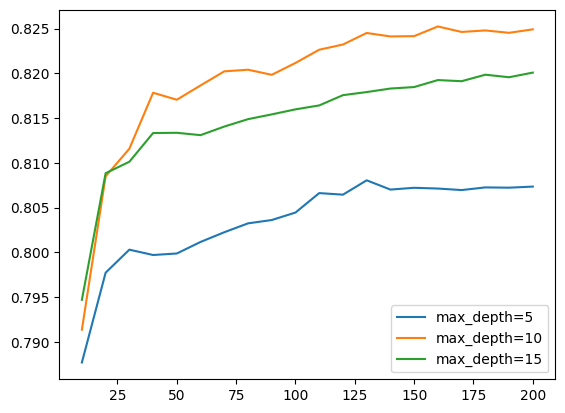

In [31]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

# Gradient Boosting Decision Tree

In [34]:
import xgboost as xgb

In [35]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/home/rollytiger/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [37]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8152745150274878

In [38]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [39]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [40]:
s = output.stdout

In [41]:
print(s[:200])

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	tr
